# HW.8 Seq2Seq

- 英文翻譯中文

    - 輸入： 一句英文 （e.g. tom is a student .）
    - 輸出： 中文翻譯 （e.g. 湯姆 是 個 學生 。）
- TODO

    - 实现 Attention Mechanism
    - 实现 Beam Search
    - 实现 Schedule Sampling

## Dataset



In [1]:
!gdown --id '1r4px0i-NcrnXy1-tkBsIwvYwbWnxAhcg' --output data.tar.gz
!tar -zxvf data.tar.gz
!mkdir ckpt
!ls

Downloading...
From: https://drive.google.com/uc?id=1r4px0i-NcrnXy1-tkBsIwvYwbWnxAhcg
To: /content/data.tar.gz
5.83MB [00:00, 22.1MB/s]
cmn-eng/
cmn-eng/int2word_cn.json
cmn-eng/int2word_en.json
cmn-eng/preprocess/
cmn-eng/preprocess/build_dataset.py
cmn-eng/preprocess/build_dictionary.sh
cmn-eng/preprocess/cmn.txt
cmn-eng/preprocess/cn.txt
cmn-eng/preprocess/dict.txt.big
cmn-eng/preprocess/dict.txt.small
cmn-eng/preprocess/en.txt
cmn-eng/preprocess/en_code.txt
cmn-eng/preprocess/en_refine.txt
cmn-eng/preprocess/en_vocab.txt
cmn-eng/preprocess/tokenizer.py
cmn-eng/testing.txt
cmn-eng/training.txt
cmn-eng/validation.txt
cmn-eng/word2int_cn.json
cmn-eng/word2int_en.json
ckpt  cmn-eng  data.tar.gz  drive  sample_data


In [ ]:
! pip3 install --user nltk

In [32]:
import json
import os
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optimz
import numpy as np
import pandas as pd
import jieba
import random
from torch.utils.data import Dataset,DataLoader
from gensim.models import word2vec
import warnings
warnings.filterwarnings('ignore')

## Data preprocess

In [33]:
class data_preprocess():
    def __init__(self, embed_dim):
        self.root = './cmn-eng'
        self.embed_dim = embed_dim
        self.cn_int2word, self.cn_word2int = self.get_dictionary('cn')
        self.en_int2word, self.en_word2int = self.get_dictionary('en')

    def get_dictionary(self, language):
        """
        Load the vocabulary
        return:
            int2word, word2int : dic of vocabulary
        """
        with open(os.path.join(self.root, f'int2word_{language}.json'), 'r') as f:
            int2word = json.load(f)
        with open(os.path.join(self.root, f'word2int_{language}.json'), 'r') as f:
            word2int = json.load(f)
        return int2word, word2int

    def train_word2vec(self, en_data, cn_data):
        """
        Train the word2vec model
        return:
            None
        """
        self.en_word2vec = word2vec.Word2Vec(en_data, size = self.embed_dim, window = 5, min_count = 2)
        self.cn_word2vec = word2vec.Word2Vec(cn_data, size = self.embed_dim, window = 5, min_count = 2) 

    def added_embedding(self):
        """
        Initial tag embedding <PAD><BOS><EOS><UNK>
        """
        pad_vector = torch.empty(1, self.embed_dim)
        vector = torch.empty(3, self.embed_dim)
        torch.nn.init.uniform_(vector)
        return torch.cat([pad_vector, vector], 0)

    def build_embedding(self):
        """
        Build the embedding matrix for nn.Embedding
        return:
            en_embedding,cn_embedding : tensor of vocab_size * embed_dim
        """
        en_add_embedding = self.added_embedding()
        en_embedding = np.empty((len(self.en_word2int), self.embed_dim))
        for word in self.en_word2int:
            en_embedding[self.en_word2int[word],:] = self.en_word2vec[word] if word in self.en_word2vec else en_add_embedding[3,:]
        self.en_embed_matrix = torch.cat([en_add_embedding, torch.tensor(en_embedding[4:],dtype = torch.float)], 0) 

        cn_add_embedding = self.added_embedding()
        cn_embedding = np.empty((len(self.cn_word2int), self.embed_dim))
        for word in self.cn_word2int:
            cn_embedding[self.cn_word2int[word],:] = self.cn_word2vec[word] if word in self.cn_word2vec else cn_add_embedding[3,:]
        self.cn_embed_matrix = torch.cat([cn_add_embedding, torch.tensor(cn_embedding[4:],dtype = torch.float)], 0)
        return self.en_embed_matrix, self.cn_embed_matrix
    
    def pad_sequence(self, seq, max_len):
        """
        Padding sequence '[BOS] sequences [EOS]' fixed length = max_len
        return:
            fixed length sequence
        """
        seq.insert(0,1)
        seq_out = [0]*max_len
        seq = seq[:max_len-1]
        seq.append(2)
        seq_out[:len(seq)] = seq
        return seq_out

    def seq_preprocess(self, sequence, max_len):
        """
        Take the input word sequnence to index sequence and padding to fixed length
        return:
            en_out,cn_out : list of fixed length
        """
        x = sequence.strip('\n').split('\t')
        # word to index 
        en_idx = [self.en_word2int[word] if word in self.en_word2int else self.en_word2int['<UNK>'] for word in x[0].split()]
        cn_idx = [self.cn_word2int[word] if word in self.cn_word2int else self.cn_word2int['<UNK>'] for word in x[1].split()]
        # padding
        en_out = self.pad_sequence(en_idx, max_len)
        cn_out = self.pad_sequence(cn_idx, max_len)  
        return en_out,cn_out
     

### Load word2vec data

In [34]:
def load_train_data(path):
    """
    Load the corpis to train the word2vec
    return:
        en_data, cn_data : corpus for word2vec training
    """
    with open(path, 'r') as f:
        en_data,cn_data = [],[]
        lines = f.readlines()
        for line in lines:
            seq = line.strip('\n').split('\t')
            en_data.append(seq[0].split())
            cn_data.append(seq[1].split()) 
        return en_data,cn_data

### Build data process

In [35]:
def build_data_process(path_list, embed_dim):
    """
    return:
        process : class data_preprocess 
        en_embedding : english word2vec | array of vocab_size * embed_dim
        cn_embedding : chinese word2vec | array of vacab_size * embed_dim
    """
    en_train_vec, cn_train_vec = [],[]
    for path in path_list:
        en_data, cn_data = load_train_data(path)
        en_train_vec += en_data
        cn_train_vec += cn_data
    
    process = data_preprocess(embed_dim)
    process.train_word2vec(en_train_vec, cn_train_vec)
    en_embedding,cn_embedding = process.build_embedding()
    return process, en_embedding, cn_embedding

In [36]:
class TextDataSet(Dataset):
    def __init__(self, path, process, max_len):
        with open(path, 'r') as f:
            self.en, self.cn = [],[]
            for line in f.readlines():
                en_seq, cn_seq = process.seq_preprocess(line, max_len)
                self.en.append(en_seq)
                self.cn.append(cn_seq)
            assert len(self.cn) == len(self.en)
    
    def __len__(self):
        return len(self.en)

    def __getitem__(self,index):
        return np.array(self.en[index]), np.array(self.cn[index])

## Model

### Dynamic RNN

In [37]:
class Dynamic_RNN(nn.Module):
    # Dynamic RNN with sequence pad
    def __init__(self, input_dim, hidden_dim, Type = 'LSTM', num_layers = 1, nonlinearity = 'tanh', bias = True, batch_first = True, dropout = 0, bidirectional = False):
        super(Dynamic_RNN, self).__init__()
        self.batch_first = batch_first
        self.rnn_type = Type
        if Type == 'RNN':
            self.RNN = nn.RNN(input_size = input_dim, hidden_size = hidden_dim, num_layers = num_layers,bias = bias, dropout = dropout, batch_first = batch_first, bidirectional = bidirectional)
        elif Type == 'LSTM':
            self.RNN = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, num_layers = num_layers,bias = bias, dropout = dropout, batch_first = batch_first, bidirectional = bidirectional)
        else:
            self.RNN = nn.GRU(input_size = input_dim, hidden_size = hidden_dim, num_layers = num_layers,bias = bias, dropout = dropout, batch_first = batch_first, bidirectional = bidirectional)

    def forward(self,x,x_len,hidden):
        x_sort_idx = torch.sort(-x_len)[1].long()
        x_unsort_idx = torch.sort(x_sort_idx)[1].long()
        x_len = x_len[x_sort_idx]
        x = x[x_sort_idx]

        x_embed_pad = torch.nn.utils.rnn.pack_padded_sequence(x, x_len, batch_first = self.batch_first)
        if self.rnn_type == 'LSTM':
            out_pack,(h_t,c_t) = self.RNN(x_embed_pad,hidden)
        else:
            out_pack, h_t = self.RNN(x_embed_pad,hidden)
            c_t = None
        
        h_t = torch.transpose(h_t, 0, 1)[x_unsort_idx] 
        h_t = torch.transpose(h_t, 0, 1)

        out = torch.nn.utils.rnn.pad_packed_sequence(out_pack, batch_first = self.batch_first)
        out = out[0]
        out = out[x_unsort_idx]
        if self.rnn_type == 'LSTM':
            c_t = torch.transpose(c_t, 0, 1)[x_unsort_idx]
            c_t = torch.transpose(c_t, 0, 1)
        return out,(h_t,c_t)  

### Encoder

In [264]:
class Encoder(nn.Module):
    # Encoder model
    def __init__(self, embed_matrix, layers = 1, hidden_dim = 128):
        super(Encoder, self).__init__()
        self.embed_dim = embed_matrix.shape[1]
        self.embed = nn.Embedding.from_pretrained(embed_matrix)
        self.rnn = Dynamic_RNN(self.embed_dim, hidden_dim, Type = 'GRU',num_layers = layers)

    def forward(self, inputs):
        inputs_len = torch.tensor(torch.sum(inputs != 0,dim = -1),dtype = torch.float)
        tokens = self.embed(inputs)
        out,(h_t,_) = self.rnn(tokens, inputs_len, None)
        return out,h_t

### Decoder

In [265]:
class Decoder(nn.Module):
    # Decoder model
    def __init__(self, embed_matrix, layers = 1, hidden_dim = 128 ,dropout = 0.5):
        super(Decoder, self).__init__()
        self.embed_dim = embed_matrix.shape[1]
        self.out_dim = embed_matrix.shape[0]
        self.embedding = nn.Embedding.from_pretrained(embed_matrix)
        self.RNN = Dynamic_RNN(self.embed_dim, hidden_dim, Type = 'GRU', num_layers = layers)
        self.dense = nn.Sequential(
                        #nn.Dropout(dropout),
                        nn.Linear(hidden_dim, hidden_dim * 2),
                        nn.Linear(hidden_dim * 2, self.out_dim),
                        #nn.Softmax(dim = 2)
                    )

    def forward(self, inputs, hidden):
        inputs_len = torch.tensor(torch.sum(inputs != 0,dim = -1),dtype = torch.float)
        tokens = self.embedding(inputs)
        out,(h_t,_) = self.RNN(tokens, inputs_len, hidden)
        out = self.dense(out) 
        return out,h_t

### Attention

In [266]:
class Attention(nn.Module):
    pass

### Seq2Seq

In [278]:
class Seq2Seq(nn.Module):
    # Sequence to Sequence model
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, inputs, target, teacher_forcing_ratio):
        batch_size = target.shape[0]
        target_len = target.shape[1]
        vocab_size = self.decoder.out_dim

        outputs = torch.zeros(batch_size, target_len, vocab_size).to(self.device)

        encoder_out, encoder_ht = self.encoder(inputs)
        decoder_in = torch.zeros((batch_size,target_len)).long()
        preds = []
        # Decoder
        decoder_in[:,0] = target[:,0]
        for t in range(1,target_len):
            decoder_out, hid = self.decoder(decoder_in.to(self.device), encoder_ht)

            if t == decoder_out.shape[1]+1:
                break
            outputs[:,t] = decoder_out[:,t-1]
            top = decoder_out.argmax(-1)

            if random.random() < teacher_forcing_ratio and torch.sum(target[:,t]) != 0:
                decoder_in[:,t] = target[:,t]
            else:
                decoder_in[:,t] = top[:,t-1] 

        return outputs,top


## Utils

- Basic operation
    - Save Model
    - Load Model
    - Build Model
    - Tokens to Sequence
    - Compute BLEU score
    


### Save Model

In [279]:
def save_model(model, store_model_path, step):
    torch.save(model.state_dict(), f'{store_model_path}/model_{step}.cpkt')

### Load Model

In [280]:
def load_model(model, load_model_path):
    model.load_state_dict(torch.load(f'{load_model_path}.ckpt'))
    return model

### Build Model

In [281]:
def build_model(config,en_embed,cn_embed):
    encoder = Encoder(en_embed, layers = config.num_layers, hidden_dim = config.hidden_dim)
    decoder = Decoder(cn_embed, layers = config.num_layers, hidden_dim = config.hidden_dim, dropout = config.dropout)
    model = Seq2Seq(encoder,decoder,config.device)
    optimizer = optimz.Adam(model.parameters(), lr = config.learning_rate, weight_decay = config.weight_decay)
    
    if config.load_model:
        model = load_model(model, config.load_model_path)

    model = model.to(config.device)
    return model,optimizer

### Tokens to Sequence

In [282]:
def tokens_to_sequence(outputs, int2word):
    """
    Transform tokens into a sequence
    return :
        sentence of word character
    """
    sentences = []
    for tokens in outputs:
        sentence = []
        for token in tokens:
            word = int2word[str(int(token))]
            if word == '<EOS>':
                break
            sentence.append(word)
        sentences.append(sentence)
    return sentences

### Compute BLEU score

In [283]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

def compute_bleu(sentences, target):
    """
    Compute the BLEU score between the predict sequence and target
    return :
        BLEU score of one batch
    """
    score = 0
    assert (len(sentences) == len(targets))

    def cut_token(sentence):
        """
        Split the sentence into character level list
        return:
            tmp : the list of character tokens
        """
        tmp = []
        for toekn in sentence:
            if token == '<UNK>' or token.isdigit() or len(bytes(token[0], encoding = 'utf-8')) == 1:
                tmp.append(token)
            else:
                tmp += [word for word in token]
        return tmp
    
    for sentence, target in zip(sentence, targets):
        sentenc = cut_token(sentence)
        target = cut_token(target)
        score += sentence_bleu([target], sentence, weights=(1,0,0,0))
    return score

### Config

In [284]:
class Config(object):
    def __init__(self):
        self.batch_size = 64
        self.embed_dim = 256
        self.hidden_dim = 128
        self.num_layers = 1
        self.dropout = 0.5
        self.learning_rate = 1e-5
        self.weight_decay = 1e-2
        self.epoch_num = 200
        self.max_len = 16
        self.store_epoch = 200
        self.load_model = False
        self.store_model_path = "./ckpt"      
        self.load_model_path = None
        self.data_path = "./cmn-eng"          
        self.attention = False 
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'


## Train

In [318]:
def train(model, optimizer, train_iter, loss_func, epoch_num, device):
    model.train()
    model.zero_grad()
    losses = []
    loss_sum = []

    for step in range(epoch_num):
        for idx,data in enumerate(train_iter):
           sources = data[0].to(device)
           targets = data[1].to(device)
           outputs, preds = model(sources, targets, 1)
           
           outputs = outputs[:,1:].reshape(-1, outputs.size(2))
           targets = targets[:,1:].reshape(-1)
           loss = loss_func(outputs, targets)

           optimizer.zero_grad() 
           loss.backward()
           #grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
           optimizer.step()
           loss_sum.append(loss.item())

        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(loss_sum)
        plt.xlabel('次數')
        plt.ylabel('loss')
        plt.title('train loss')
        plt.show()
        
    return model, optimizer , losses

### Train process

In [319]:
def train_process(config):
    process, en_embed, cn_embed =  build_data_process(['./cmn-eng/training.txt','./cmn-eng/validation.txt'],config.embed_dim)
    assert len(process.en_word2int) == en_embed.shape[0]
    assert len(process.cn_word2int) == cn_embed.shape[0]

    data = TextDataSet('./cmn-eng/training.txt', process, config.max_len)
    data_loader = DataLoader(data, batch_size = config.batch_size, shuffle = True, drop_last = False)

    model, optimizer = build_model(config, en_embed, cn_embed)
    loss_func = nn.CrossEntropyLoss()
    print(model)
    print(optimizer)
    model, optimizer, train_loss = train(model, optimizer, data_loader, loss_func, config.epoch_num, config.device)
    return train_loss

In [320]:
def main():
    config = Config()
    losss = train_process(config)

Seq2Seq(
  (encoder): Encoder(
    (embed): Embedding(3922, 256)
    (rnn): Dynamic_RNN(
      (RNN): GRU(256, 128, batch_first=True)
    )
  )
  (decoder): Decoder(
    (embedding): Embedding(3805, 256)
    (RNN): Dynamic_RNN(
      (RNN): GRU(256, 128, batch_first=True)
    )
    (dense): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=3805, bias=True)
    )
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0.01
)


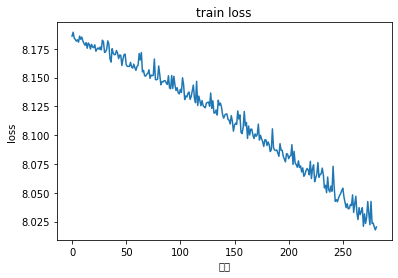

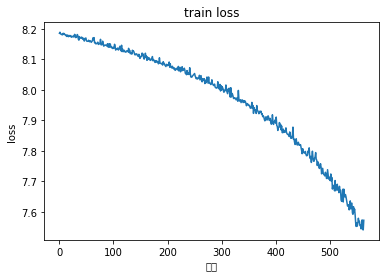

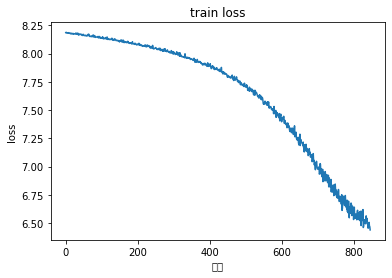

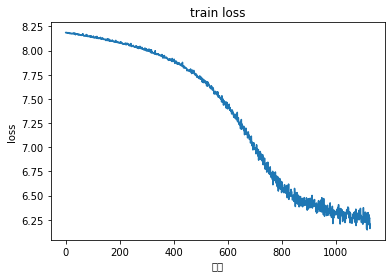

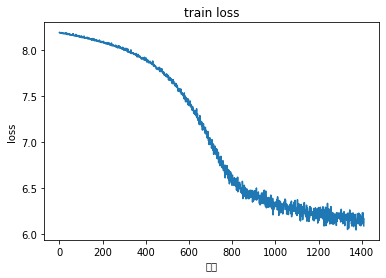

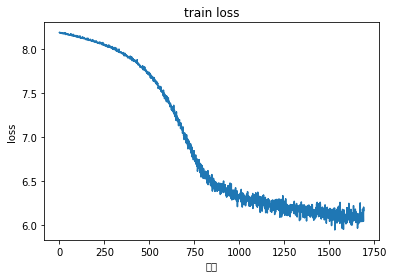

In [ ]:
main()